1
DETAILS OF RUN WITH INDEX: 1
################### Beginning of run 1 ###################
|t''| = 0.3, d = 0.01


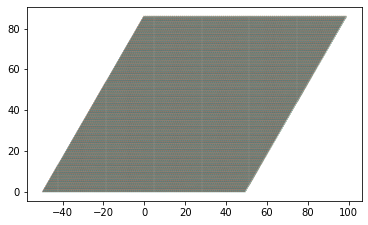

<ipython-input-40-e74bfd99be48>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  kwant.plotter.density(syst, rho.real, ax=ax)
<ipython-input-40-e74bfd99be48>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  kwant.plotter.density(syst, rho.real, ax=ax)


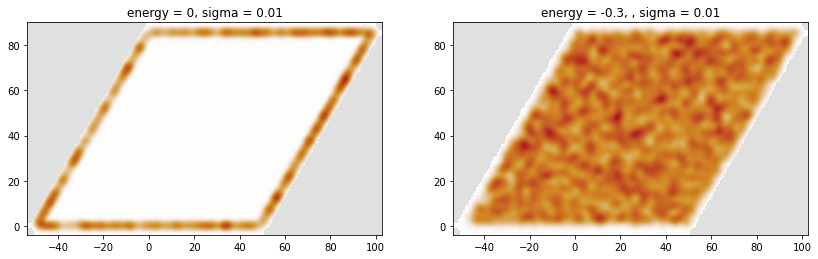

Averaging: 1 / 1
################### End of run 1 ###################


'Run 1 Succeeded!'

<Figure size 432x288 with 0 Axes>

In [40]:
import concurrent
import multiprocessing as mp
import time
import kwant
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt

##########
# BUILD  #
##########

def plot_ldos(syst, densities, file_name=None):
    fig, axes = plt.subplots(1, len(densities), figsize=(7*len(densities), 7))
    for ax, (title, rho) in zip(axes, densities):
        kwant.plotter.density(syst, rho.real, ax=ax)
        ax.set_title(title)
        ax.set(adjustable='box', aspect='equal')
    plt.savefig("./plots/kagome/gaussian/N3_Kagome_Gauss_t3_0.3_L_100_sigma_0.01.pdf")
    plt.show()
    plt.clf()

def ldos_example(fsyst):
    # 'sum=False' is the default, but we include it explicitly here for clarity.
    kwant_op = kwant.operator.Density(fsyst, sum=False)
    local_dos = kwant.kpm.SpectralDensity(fsyst, operator=kwant_op, rng=0)

    zero_energy_ldos = local_dos(energy=0)
    finite_energy_ldos = local_dos(energy=-0.3)
    plot_ldos(fsyst, [
        ('energy = 0, sigma = 0.01', zero_energy_ldos),
        ('energy = -0.3, , sigma = 0.01', finite_energy_ldos)
    ])

def plot_system(syst):
    kwant.plot(syst)
    
def make_system(t1, t2, t3, tn, lat_const, L, d, type_kagome='monolayer'):
    Bravais_vector = [(lat_const, 0),
                      (0.5 * lat_const, 0.5 * lat_const * sqrt(3))]  # Bravais vectors
    Bottom_Lat_pos = [(0.5 * lat_const, 0), (0.25 * lat_const, 0.25 * lat_const * sqrt(3)),
                      (0, 0)]  # The position of sublattice atoms in Bottom layer
    Upper_Lat_pos = [(0, 0), (-0.5 * lat_const, 0), (
        -0.25 * lat_const, -0.25 * lat_const * sqrt(3))]  # The position of sublattice atoms in Upper layer

    Bottom_lat = kwant.lattice.general(Bravais_vector, Bottom_Lat_pos, norbs=1)
    B_sub_a, B_sub_b, B_sub_c = Bottom_lat.sublattices

    if type_kagome == 'bilayer':
        Upper_lat = kwant.lattice.general(Bravais_vector, Upper_Lat_pos, norbs=1)
        U_sub_a, U_sub_b, U_sub_c = Upper_lat.sublattices

        # sym = kwant.TranslationalSymmetry(Bravais_vector[0], Bravais_vector[1])
    bulk = kwant.Builder()

    for x in range(int(-L / 2), int(L / 2)):
        for y in range(0, int(L)):
            # define hopping and on-site potential on bottom layer kagome
            bulk[B_sub_a(x, y)] = np.random.normal(0, d, 1)
            bulk[B_sub_b(x, y)] = np.random.normal(0, d, 1)
            bulk[B_sub_c(x, y)] = np.random.normal(0, d, 1)

    bulk[kwant.builder.HoppingKind((0, 0), B_sub_b, B_sub_a)] = t1
    bulk[kwant.builder.HoppingKind((0, 0), B_sub_c, B_sub_b)] = t1
    bulk[kwant.builder.HoppingKind((0, 0), B_sub_a, B_sub_c)] = t1
    bulk[kwant.builder.HoppingKind((-1, 0), B_sub_a, B_sub_c)] = t1
    bulk[kwant.builder.HoppingKind((0, 1), B_sub_c, B_sub_b)] = t1
    bulk[kwant.builder.HoppingKind((1, -1), B_sub_b, B_sub_a)] = t1

    # Next neighbors

    bulk[kwant.builder.HoppingKind((0, 1), B_sub_c, B_sub_a)] = t2
    bulk[kwant.builder.HoppingKind((1, -1), B_sub_c, B_sub_a)] = t2
    # bulk[kwant.builder.HoppingKind((1,0), B_sub_b,B_sub_a)] = t2
    # bulk[kwant.builder.HoppingKind((0,-1), B_sub_b,B_sub_a)] = t2
    bulk[kwant.builder.HoppingKind((-1, 0), B_sub_a, B_sub_b)] = t2
    bulk[kwant.builder.HoppingKind((0, 1), B_sub_a, B_sub_b)] = t2
    # bulk[kwant.builder.HoppingKind((1,0), B_sub_c,B_sub_b)] = t2
    # bulk[kwant.builder.HoppingKind((-1,1), B_sub_c,B_sub_b)] = t2
    bulk[kwant.builder.HoppingKind((1, -1), B_sub_b, B_sub_c)] = t2
    bulk[kwant.builder.HoppingKind((-1, 0), B_sub_b, B_sub_c)] = t2
    # bulk[kwant.builder.HoppingKind((-1,1), B_sub_a,B_sub_c)] = t2
    # bulk[kwant.builder.HoppingKind((0,-1),B_sub_a,B_sub_c)] = t2

    # Next nearest neighbors

    # bulk[kwant.builder.HoppingKind((1,0), B_sub_a,B_sub_a)] = t3
    bulk[kwant.builder.HoppingKind((0, 1), B_sub_a, B_sub_a)] = t3
    # bulk[kwant.builder.HoppingKind((-1,1), B_sub_a,B_sub_a)] = t3

    bulk[kwant.builder.HoppingKind((1, 0), B_sub_b, B_sub_b)] = t3
    # bulk[kwant.builder.HoppingKind((0,1),B_sub_b,B_sub_b)] = t3
    # bulk[kwant.builder.HoppingKind((-1,1), B_sub_b,B_sub_b)] = t3

    # bulk[kwant.builder.HoppingKind((1,0), B_sub_c,B_sub_c)] = t3
    # bulk[kwant.builder.HoppingKind((0,1), B_sub_c,B_sub_c)] = t3
    bulk[kwant.builder.HoppingKind((-1, 1), B_sub_c, B_sub_c)] = t3

    # define hopping and on-site potential on upper layer kagome

    if type_kagome == 'bilayer':
        bulk[U_sub_a(0, 0)] = np.random.normal(0, 1, 1)
        bulk[U_sub_b(0, 0)] = np.random.normal(0, 1, 1)
        bulk[U_sub_c(0, 0)] = np.random.normal(0, 1, 1)

        bulk[kwant.builder.HoppingKind((0, 0), B_sub_a, B_sub_b)] = t1
        bulk[kwant.builder.HoppingKind((0, 0), B_sub_b, B_sub_c)] = t1
        bulk[kwant.builder.HoppingKind((0, 0), B_sub_c, B_sub_a)] = t1
        bulk[kwant.builder.HoppingKind((-1, 0), B_sub_a, B_sub_c)] = t1
        bulk[kwant.builder.HoppingKind((0, 1), B_sub_c, B_sub_b)] = t1
        bulk[kwant.builder.HoppingKind((1, -1), B_sub_b, B_sub_a)] = t1

        # Next neighbors

        bulk[kwant.builder.HoppingKind((0, 1), U_sub_c, U_sub_a)] = t2
        bulk[kwant.builder.HoppingKind((1, -1), U_sub_c, U_sub_a)] = t2
        bulk[kwant.builder.HoppingKind((1, 0), U_sub_b, U_sub_a)] = t2
        bulk[kwant.builder.HoppingKind((0, -1), U_sub_b, U_sub_a)] = t2
        bulk[kwant.builder.HoppingKind((-1, 0), U_sub_a, U_sub_b)] = t2
        bulk[kwant.builder.HoppingKind((0, 1), U_sub_a, U_sub_b)] = t2
        bulk[kwant.builder.HoppingKind((1, 0), U_sub_c, U_sub_b)] = t2
        bulk[kwant.builder.HoppingKind((-1, 1), U_sub_c, U_sub_b)] = t2
        bulk[kwant.builder.HoppingKind((1, -1), U_sub_b, U_sub_c)] = t2
        bulk[kwant.builder.HoppingKind((-1, 0), U_sub_b, U_sub_c)] = t2
        bulk[kwant.builder.HoppingKind((-1, 1), U_sub_a, U_sub_c)] = t2
        bulk[kwant.builder.HoppingKind((0, -1), U_sub_a, U_sub_c)] = t2

        bulk[kwant.builder.HoppingKind((0, 0), U_sub_a, B_sub_b)] = tn
        bulk[kwant.builder.HoppingKind((0, 0), U_sub_b, B_sub_c)] = tn
        bulk[kwant.builder.HoppingKind((0, 0), U_sub_c, B_sub_a)] = tn
        bulk[kwant.builder.HoppingKind((0, 0), U_sub_b, B_sub_a)] = tn
        bulk[kwant.builder.HoppingKind((0, 0), U_sub_c, B_sub_b)] = tn
        bulk[kwant.builder.HoppingKind((0, 0), U_sub_a, B_sub_c)] = tn

    return bulk


# Different geometries of the finite system

def trunc(site):
    x, y = abs(site.pos)
    return abs(x) < 800 and abs(y) < 800


def circle(site):
    x, y = site.pos
    r = 30
    return x ** 2 + y ** 2 < r ** 2


# Declare big things coming


def cluster_run(run_index):
    run_num = int(run_index[0])
    print(run_num)
    np.random.seed(run_num)
    print("DETAILS OF RUN WITH INDEX: " + str(run_num))
    print("################### Beginning of run " + str(run_num) + " ###################")

    # Default settings

    lat_const = 1  # lattice constant of kagome (unit: nm)
    tn = 0.0  # interlayer hopping between kagomes (unit: eV)
    L = 100  # size of the system (in each dimension)
    averaging = 1  # number of runs for averaging DOS and conductivities

    # Domains of cond function for later

    N_bins = 100  # Bins for energies in the estimator
    N_binsT = 500  # Bins for temperature
    T_min = 0.01
    T_max = 5.00
    T = np.linspace(T_min, T_max, N_binsT)

    x = run_index[1]
    d = run_index[2]

    print("|t''| = " + str(x) + ", d = " + str(d))

    all_energies = []
    all_densities = []
    all_cond_xx_miu = []
    all_cond_xy_miu = []
    all_T = []
    all_cond_xx_T = []
    all_cond_xy_T = []

    for av in range(0, averaging):
        # Hoppings

        t1 = -0.25
        t2 = -0.25
        t3 = -x

        syst = kwant.Builder()
        model = make_system(t1, t2, t3, tn, lat_const, L, d, type_kagome='monolayer')
        area_per_site = np.abs(lat_const * lat_const * np.sqrt(3) / 2) / 3
        syst.fill(model, trunc, (0, 0));

        syst.eradicate_dangling()

        # Plot system before running

        # kwant.plot(syst);

        fsyst = syst.finalized()
        
        plot_system(syst)
        
        # Evaluate DOS
        
        # This is LDoS at particular energies
        
        ldos_example(fsyst)
        
        rho = kwant.kpm.SpectralDensity(fsyst)
        energies, densities = rho()
        print("Averaging:", av + 1, "/", averaging)

        # Evaluate conductivity tensor

        where = lambda s: np.linalg.norm(s.pos) < 1

        # xx component

        s_factory = kwant.kpm.LocalVectors(fsyst, where)
        cond_xx = kwant.kpm.conductivity(fsyst, alpha='x', beta='x', num_vectors=None, vector_factory=s_factory)
        # cond_xx = kwant.kpm.conductivity(fsyst, alpha='x', beta='x')

        cond_xx_miu = [cond_xx(mu=e, temperature=0.01) / (area_per_site) for e in energies]
        # print("-----mu------")
        # print([(cond_xx_miu[i], energies[i]) for i in range(0, len(energies))])
        # print()
        cond_xx_T = [cond_xx(mu=-1, temperature=T[i]) / (area_per_site) for i in range(len(T))]

        # xy component

        s_factory = kwant.kpm.LocalVectors(fsyst, where)
        cond_xy = kwant.kpm.conductivity(fsyst, alpha='x', beta='y', num_vectors=None, vector_factory=s_factory)
        # cond_xy = kwant.kpm.conductivity(fsyst, alpha='x', beta='y')

        cond_xy_miu = [cond_xy(mu=e, temperature=0.01) / (area_per_site) for e in energies]
        cond_xy_T = [cond_xy(mu=-1, temperature=T[i]) / (area_per_site) for i in range(len(T))]

        # For estimator

        all_energies += list(energies)
        all_densities += list(densities)
        all_cond_xx_miu += list(cond_xx_miu)
        all_cond_xy_miu += list(cond_xy_miu)
        all_T += list(T)
        all_cond_xx_T += list(cond_xx_T)
        all_cond_xy_T += list(cond_xy_T)

    #############
    # Estimator #
    #############

    E_min = min(all_energies)
    E_max = max(all_energies)

    est_energies = [0] * N_bins
    est_densities = [0] * N_bins
    est_cond_xx_miu = [0] * N_bins
    est_cond_xy_miu = [0] * N_bins
    est_cond_xx_T = [0] * N_binsT
    est_cond_xy_T = [0] * N_binsT
    bin_n = [0] * N_bins
    bin_nT = [0] * N_binsT

    # Conductivity as function of chemical potential, setting up DOS for averaging

    for i in range(0, len(all_energies)):
        bin = int(np.floor((all_energies[i] - E_min) / (E_max - E_min) * N_bins))
        if (bin >= N_bins or bin < 0):
            continue

        est_energies[bin] += all_energies[i]
        est_densities[bin] += all_densities[i]
        est_cond_xx_miu[bin] += all_cond_xx_miu[i]
        est_cond_xy_miu[bin] += all_cond_xy_miu[i]

        bin_n[bin] += 1

    def not_zero(b):
        if b == 0:
            return 1
        return b

    bin_n = [not_zero(b) for b in bin_n]

    est_energies = [est_energies[i] / (bin_n[i]) for i in range(0, N_bins)]
    est_densities = [est_densities[i] / (bin_n[i]) for i in range(0, N_bins)]
    est_cond_xx_miu = [est_cond_xx_miu[i] / (bin_n[i]) for i in range(0, N_bins)]
    est_cond_xy_miu = [est_cond_xy_miu[i] / (bin_n[i]) for i in range(0, N_bins)]

    # Normalisation of DOS

    Norm_D = 0

    for i in range(0, len(est_energies)):
        Norm_D += est_densities[i] * (E_max - E_min) / N_bins

    est_densities = [est_densities[i] / Norm_D for i in range(0, N_bins)]

    # Conductivity as function of temperature

    for i in range(0, len(all_T)):
        bin = int(np.floor((all_T[i] - T_min) / (T_max - T_min) * N_binsT))
        if (bin >= N_binsT or bin < 0):
            continue

        est_cond_xx_T[bin] += all_cond_xx_T[i]
        est_cond_xy_T[bin] += all_cond_xy_T[i]

        bin_nT[bin] += 1

    def not_zero(b):
        if b == 0:
            return 1
        return b

    bin_nT = [not_zero(b) for b in bin_nT]

    est_cond_xx_T = [est_cond_xx_T[i] / (bin_nT[i]) for i in range(0, N_binsT)]
    est_cond_xy_T = [est_cond_xy_T[i] / (bin_nT[i]) for i in range(0, N_binsT)]

    ############
    # SAVING   #
    ############

#     file_name = "./data/N3euler/gaussian/L_100/Euler_DOS_dis_full_" + str(d) + "_tNNNN_" + str(x) + "_L_" + str(L) + ".dat"
#     with open(file_name, "x") as file_fd:
#         for i in range(0, len(est_energies)):
#             file_fd.write(
#                 str(est_energies[i]) + " " + str(est_densities[i]) + " " + str(est_cond_xx_miu[i]) + " " + str(
#                     est_cond_xy_miu[i]) + "\n")
    
    print("################### End of run " + str(run_num) + " ###################")
    return "Run " + str(run_num) + " Succeeded!"


# def main():
#     print("Number of processors: ", mp.cpu_count())

#     xs = [0.00, 0.05, 0.25, 0.50, 1.00]
#     ds = [0.01, 0.1, 0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0]

#     row = len(xs) * len(ds)
#     col = 3

#     run_table = np.ones((row, col))
#     cnt = 1
#     for i in range(len(xs)):
#         for j in range(len(ds)):
#             run_table[i * len(ds) + j, 0] = cnt
#             run_table[i * len(ds) + j, 1] = xs[i]
#             run_table[i * len(ds) + j, 2] = ds[j]
#             cnt += 1

#     start = time.perf_counter()

#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         results = executor.map(cluster_run, run_table)

#         for result in results:
#             print(result)

#     finish = time.perf_counter()

#     print("Results:\n", results, f" Time period: {round(finish - start, 2)}")


# if __name__ == '__main__':
#     main()


cluster_run([1, 0.3, 0.01])



In [ ]:
# Tutorial 2.8. Calculating spectral density with the Kernel Polynomial Method
# ============================================================================
#
# Physics background
# ------------------
#  - Chebyshev polynomials, random trace approximation, spectral densities.
#
# Kwant features highlighted
# --------------------------
#  - kpm module,kwant operators.

import scipy

# For plotting
from matplotlib import pyplot as plt

# necessary imports
import kwant
import numpy as np


# define the system
def make_syst(r=30, t=-1, a=1):
    syst = kwant.Builder()
    lat = kwant.lattice.honeycomb(a, norbs=1)

    def circle(pos):
        x, y = pos
        return x ** 2 + y ** 2 < r ** 2

    syst[lat.shape(circle, (0, 0))] = 0.
    syst[lat.neighbors()] = t
    syst.eradicate_dangling()

    return syst

# define a Haldane system
def make_syst_topo(r=30, a=1, t=1, t2=0.5):
    syst = kwant.Builder()
    lat = kwant.lattice.honeycomb(a, norbs=1, name=['a', 'b'])

    def circle(pos):
        x, y = pos
        return x ** 2 + y ** 2 < r ** 2

    syst[lat.shape(circle, (0, 0))] = 0.
    syst[lat.neighbors()] = t
    # add second neighbours hoppings
    syst[lat.a.neighbors()] = 1j * t2
    syst[lat.b.neighbors()] = -1j * t2
    syst.eradicate_dangling()

    return lat, syst.finalized()


# define the system
def make_syst_staggered(r=30, t=-1, a=1, m=0.1):
    syst = kwant.Builder()
    lat = kwant.lattice.honeycomb(a, norbs=1)

    def circle(pos):
        x, y = pos
        return x ** 2 + y ** 2 < r ** 2

    syst[lat.a.shape(circle, (0, 0))] = m
    syst[lat.b.shape(circle, (0, 0))] = -m
    syst[lat.neighbors()] = t
    syst.eradicate_dangling()

    return syst

# Plot several density of states curves on the same axes.
def plot_dos(labels_to_data):
    plt.figure(figsize=(5,4))
    for label, (x, y) in labels_to_data:
        plt.plot(x, y.real, label=label, linewidth=2)
    plt.legend(loc=2, framealpha=0.5)
    plt.xlabel("energy [t]")
    plt.ylabel(ylabel)
    plt.show()
    plt.clf()


# Plot fill density of states plus curves on the same axes.
def plot_dos_and_curves(dos labels_to_data):
    plt.figure(figsize=(5,4))
    plt.fill_between(dos[0], dos[1], label="DoS [a.u.]",
                     alpha=0.5, color='gray')
    for label, (x, y) in labels_to_data:
        plt.plot(x, y, label=label, linewidth=2)
    plt.legend(loc=2, framealpha=0.5)
    plt.xlabel("energy [t]")
    plt.ylabel(ylabel)
    plt.show()
    plt.clf()

def site_size_conversion(densities):
    return 3 * np.abs(densities) / max(densities)


# Plot several local density of states maps in different subplots
def plot_ldos(syst, densities, file_name=None):
    fig, axes = plt.subplots(1, len(densities), figsize=(7*len(densities), 7))
    for ax, (title, rho) in zip(axes, densities):
        kwant.plotter.density(syst, rho.real, ax=ax)
        ax.set_title(title)
        ax.set(adjustable='box', aspect='equal')
    plt.show()
    plt.clf()

def simple_dos_example():
    fsyst = make_syst().finalized()

    spectrum = kwant.kpm.SpectralDensity(fsyst, rng=0)

    energies, densities = spectrum()

    energy_subset = np.linspace(0, 2)
    density_subset = spectrum(energy_subset)

    plot_dos([
        ('densities', (energies, densities)),
        ('density subset', (energy_subset, density_subset)),
    ])


def dos_integrating_example(fsyst):
    spectrum = kwant.kpm.SpectralDensity(fsyst, rng=0)

    print('identity resolution:', spectrum.integrate())

    # Fermi energy 0.1 and temperature 0.2
    fermi = lambda E: 1 / (np.exp((E - 0.1) / 0.2) + 1)

    print('number of filled states:', spectrum.integrate(fermi))


def increasing_accuracy_example(fsyst):
    spectrum = kwant.kpm.SpectralDensity(fsyst, rng=0)
    original_dos = spectrum()  # get unaltered DoS

    spectrum.add_moments(energy_resolution=0.03)

    increased_resolution_dos = spectrum()

    plot_dos([
        ('density', original_dos),
        ('higher energy resolution', increased_resolution_dos),
    ])

    spectrum.add_moments(100)
    spectrum.add_vectors(5)

    increased_moments_dos = spectrum()

    plot_dos([
        ('density', original_dos),
        ('higher number of moments', increased_moments_dos),
    ])


def operator_example(fsyst):
    # identity matrix
    matrix_op = scipy.sparse.eye(len(fsyst.sites))
    matrix_spectrum = kwant.kpm.SpectralDensity(fsyst, operator=matrix_op, rng=0)

    # 'sum=True' means we sum over all the sites
    kwant_op = kwant.operator.Density(fsyst, sum=True)
    operator_spectrum = kwant.kpm.SpectralDensity(fsyst, operator=kwant_op, rng=0)

    plot_dos([
        ('identity matrix', matrix_spectrum()),
        ('kwant.operator.Density', operator_spectrum()),
    ])


def ldos_example(fsyst):
    # 'sum=False' is the default, but we include it explicitly here for clarity.
    kwant_op = kwant.operator.Density(fsyst, sum=False)
    local_dos = kwant.kpm.SpectralDensity(fsyst, operator=kwant_op, rng=0)

    zero_energy_ldos = local_dos(energy=0)
    finite_energy_ldos = local_dos(energy=1)
    plot_ldos(fsyst, [
        ('energy = 0', zero_energy_ldos),
        ('energy = 1', finite_energy_ldos)
    ])


def ldos_sites_example():
    fsyst = make_syst_staggered().finalized()
    # find 'A' and 'B' sites in the unit cell at the center of the disk
    center_tag = np.array([0, 0])
    where = lambda s: s.tag == center_tag
    # make local vectors
    vector_factory = kwant.kpm.LocalVectors(fsyst, where)

    # 'num_vectors' can be unspecified when using 'LocalVectors'
    local_dos = kwant.kpm.SpectralDensity(fsyst, num_vectors=None,
                                          vector_factory=vector_factory,
                                          mean=False,
                                          rng=0)
    energies, densities = local_dos()
    plot_dos([
        ('A sublattice', (energies, densities[:, 0])),
        ('B sublattice', (energies, densities[:, 1])),
    ])


def vector_factory_example(fsyst):
    spectrum = kwant.kpm.SpectralDensity(fsyst, rng=0)
    # construct a generator of vectors with n random elements -1 or +1.
    n = fsyst.hamiltonian_submatrix(sparse=True).shape[0]
    def binary_vectors():
        while True:
           yield np.rint(np.random.random_sample(n)) * 2 - 1

    custom_factory = kwant.kpm.SpectralDensity(fsyst,
                                               vector_factory=binary_vectors(),
                                               rng=0)
    plot_dos([
        ('default vector factory', spectrum()),
        ('binary vector factory', custom_factory()),
    ])


def bilinear_map_operator_example(fsyst):
    rho = kwant.operator.Density(fsyst, sum=True)

    # sesquilinear map that does the same thing as `rho`
    def rho_alt(bra, ket):
        return np.vdot(bra, ket)

    rho_spectrum = kwant.kpm.SpectralDensity(fsyst, operator=rho, rng=0)
    rho_alt_spectrum = kwant.kpm.SpectralDensity(fsyst, operator=rho_alt, rng=0)

    plot_dos([
        ('kwant.operator.Density', rho_spectrum()),
        ('bilinear operator', rho_alt_spectrum()),
    ])

def conductivity_example():
    # construct the Haldane model
    lat, fsyst = make_syst_topo()
    # find 'A' and 'B' sites in the unit cell at the center of the disk
    where = lambda s: np.linalg.norm(s.pos) < 1

    # component 'xx'
    s_factory = kwant.kpm.LocalVectors(fsyst, where)
    cond_xx = kwant.kpm.conductivity(fsyst, alpha='x', beta='x', mean=True,
                                     num_vectors=None, vector_factory=s_factory,
                                     rng=0)
    # component 'xy'
    s_factory = kwant.kpm.LocalVectors(fsyst, where)
    cond_xy = kwant.kpm.conductivity(fsyst, alpha='x', beta='y', mean=True,
                                     num_vectors=None, vector_factory=s_factory,
                                     rng=0)

    energies = cond_xx.energies
    cond_array_xx = np.array([cond_xx(e, temperature=0.01) for e in energies])
    cond_array_xy = np.array([cond_xy(e, temperature=0.01) for e in energies])

    # area of the unit cell per site
    area_per_site = np.abs(np.cross(*lat.prim_vecs)) / len(lat.sublattices)
    cond_array_xx /= area_per_site
    cond_array_xy /= area_per_site
    # ldos
    s_factory = kwant.kpm.LocalVectors(fsyst, where)
    spectrum = kwant.kpm.SpectralDensity(fsyst, num_vectors=None,
                                         vector_factory=s_factory,
                                         rng=0)

    plot_dos_and_curves(
    (spectrum.energies, spectrum.densities * 8),
    [
        (r'Longitudinal conductivity $\sigma_{xx} / 4$',
         (energies, cond_array_xx / 4)),
        (r'Hall conductivity $\sigma_{xy}$',
         (energies, cond_array_xy))],
        ylabel=r'$\sigma [e^2/h]$',
        file_name='kpm_cond'
    )


def main():
    simple_dos_example()

    fsyst = make_syst().finalized()

    dos_integrating_example(fsyst)
    increasing_accuracy_example(fsyst)
    operator_example(fsyst)
    ldos_example(fsyst)
    ldos_sites_example()
    vector_factory_example(fsyst)
    bilinear_map_operator_example(fsyst)
    conductivity_example()


# Call the main function if the script gets executed (as opposed to imported).
# See <http://docs.python.org/library/__main__.html>.
if __name__ == '__main__':
    main()
